In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from IPython.display import HTML
import seaborn as sns

import os
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import time

sys.path.append("code/.")

import mglearn
from IPython.display import display

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import (
    cross_val_score, 
    cross_validate, 
    train_test_split,
    RandomizedSearchCV
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer
)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc



pd.set_option("display.max_colwidth", 200)

# 1. import data
## 1.a prepare season / game sequence data 
- this dataframe will be concatenated to player stats dfs later
- this step is used to get rid of the early-season games where there might be insufficient previous-game data

In [2]:
# count the number of games in each season
game_per_season = {}
for i in range(2014,2024):
    if i == 2020: 
        continue 
    game_info = pd.read_csv(f'data_2014_to_2024/df_{i}_game_info.csv')
    game_per_season[i] = game_info.shape[0]

# turn this into a dataframe
df_seasons = {
    "season":[],
    "game_sequence":[]
}

for key, value in game_per_season.items():
    df_seasons["season"].extend([key] * value)  # Repeat the season name for each game
    df_seasons["game_sequence"].extend(range(1, value + 1))  # Generate sequence numbers

df_seasons = pd.DataFrame(df_seasons)
print(df_seasons.shape)
df_seasons.head()

(22066, 2)


,season,game_sequence
0,2014,1
1,2014,2
2,2014,3
3,2014,4
4,2014,5


## 1.b baseline: use running_162_data.to_csv

In [3]:
# for baseline: import running_162_data.csv
running_162_data = pd.read_csv('data_2014_to_2024/running_162_data.csv').iloc[:,2:]
running_162_data.shape

(45288, 61)

## 1.c simple weighted avg: use metric_avg_game_n.csv

In [4]:
# append df_seasons from the cell above to the front of each metric_avg_game_*.csv
if 'dict_metric_avg' not in globals():
    dict_metric_avg = {}
    for i in range(1,21):
        this_df = pd.read_csv(f"data_2014_to_2024/metric_avg_game_{i}.csv", 
                            usecols=lambda column: column != 'Unnamed: 0')
        dict_metric_avg[i] = pd.concat([df_seasons,this_df.iloc[:(len(df_seasons))]], axis=1)

print(dict_metric_avg[1].shape)
dict_metric_avg[1].head()

(22066, 63)


,season,game_sequence,batavg_batter1_away_total,obp_batter1_away_total,slg_batter1_away_total,batavg_batter2_away_total,obp_batter2_away_total,slg_batter2_away_total,batavg_batter3_away_total,obp_batter3_away_total,...,batavg_batter8_home_total,obp_batter8_home_total,slg_batter8_home_total,batavg_batter9_home_total,obp_batter9_home_total,slg_batter9_home_total,era_pitcher_home_total,k9_pitcher_home_total,whip_pitcher_home_total,home_outcome
0,2014,1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2014,2,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2014,3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2014,4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2014,5,0.250000,0.250000,0.250000,0.2,0.2,0.2,0.600000,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
# for each season, only keep the last 2000 games
# the reason of doing this:
# 1. at the start of each season there are less previous game data for these early games 
# 2. some seasons include spring training games in the dataset, so to be consistent, 
#    selecting the last 2000 games will reduce the probability of introducing spring training 
#    data to our dataset. 
#    (in the project report, should justify why the spring training data got into our dataset
#     i.e. because of several overseas game that can potentially be hosted during spring training
#     while the records of these games are included as part of the regular seasons.)

for key, value in dict_metric_avg.items():
    dict_metric_avg[key] = value.groupby('season',group_keys=False).apply(lambda x: x.tail(2000))

print(dict_metric_avg[1].shape)
dict_metric_avg[1].head()

(18000, 63)


/var/folders/4f/yqk707nn61d0n9l9qmlg7f4w0000gn/T/ipykernel_9272/1218978314.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dict_metric_avg[key] = value.groupby('season',group_keys=False).apply(lambda x: x.tail(2000))
/var/folders/4f/yqk707nn61d0n9l9qmlg7f4w0000gn/T/ipykernel_9272/1218978314.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dict_metric_avg[key] = value.groupby('season',group_keys=Fal

,season,game_sequence,batavg_batter1_away_total,obp_batter1_away_total,slg_batter1_away_total,batavg_batter2_away_total,obp_batter2_away_total,slg_batter2_away_total,batavg_batter3_away_total,obp_batter3_away_total,...,batavg_batter8_home_total,obp_batter8_home_total,slg_batter8_home_total,batavg_batter9_home_total,obp_batter9_home_total,slg_batter9_home_total,era_pitcher_home_total,k9_pitcher_home_total,whip_pitcher_home_total,home_outcome
533,2014,534,0.50,0.50,1.0,0.00,0.00,0.00,0.00,0.00,...,0.333333,0.5,0.333333,0.5,0.333333,0.5,1.285714,3.000000,0.857143,1
534,2014,535,0.25,0.25,1.0,0.25,0.25,0.25,0.00,0.00,...,0.333333,0.5,0.333333,0.5,0.500000,0.5,0.000000,0.000000,0.625000,0
535,2014,536,0.20,0.20,0.4,0.20,0.20,0.20,0.75,0.80,...,0.500000,0.5,0.750000,0.0,0.000000,0.0,0.000000,0.000000,0.625000,1
536,2014,537,0.20,0.20,0.2,0.20,0.20,0.20,0.40,0.40,...,0.000000,0.0,0.000000,0.0,0.500000,0.0,0.000000,0.000000,2.000000,1
537,2014,538,0.75,0.75,1.5,0.20,0.20,0.20,0.00,0.25,...,0.333333,0.5,0.333333,0.5,0.500000,0.5,2.571429,2.571429,0.714286,1


## 1.d weighted average: use metric_each_game.csv

In [6]:
metric_each_game = pd.read_csv('data_2014_to_2024/metric_each_game.csv',
                               usecols=lambda column: column != 'Unnamed: 0')
metric_each_game = (pd
                    .concat([df_seasons,metric_each_game.iloc[:(len(df_seasons))]], axis=1)
                    .groupby('season',group_keys=False).apply(lambda x: x.tail(2000)))


/var/folders/4f/yqk707nn61d0n9l9qmlg7f4w0000gn/T/ipykernel_9272/3867328906.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('season',group_keys=False).apply(lambda x: x.tail(2000)))


In [7]:
metric_each_game.shape

(18000, 1203)

In [8]:
metric_each_game.head()

,season,game_sequence,batavg_batter1_away_1,obp_batter1_away_1,slg_batter1_away_1,batavg_batter2_away_1,obp_batter2_away_1,slg_batter2_away_1,batavg_batter3_away_1,obp_batter3_away_1,...,batavg_batter8_home_20,obp_batter8_home_20,slg_batter8_home_20,batavg_batter9_home_20,obp_batter9_home_20,slg_batter9_home_20,era_pitcher_home_20,k9_pitcher_home_20,whip_pitcher_home_20,home_outcome
533,2014,534,0.50,0.50,1.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,1
534,2014,535,0.25,0.25,1.0,0.25,0.25,0.25,0.00,0.00,...,0.25,0.250000,0.25,0.000000,0.00,0.000000,NaN,NaN,NaN,0
535,2014,536,0.20,0.20,0.4,0.20,0.20,0.20,0.75,0.80,...,0.25,0.250000,0.25,0.000000,0.00,0.000000,NaN,NaN,NaN,1
536,2014,537,0.20,0.20,0.2,0.20,0.20,0.20,0.40,0.40,...,0.00,0.333333,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,1
537,2014,538,0.75,0.75,1.5,0.20,0.20,0.20,0.00,0.25,...,0.00,0.000000,0.00,0.666667,0.75,0.666667,NaN,NaN,NaN,1


---
# 2. functions 

In [53]:
# negate values in columns containing 'away'
def negate_away_columns(X):
    X = X.copy()  # Avoid modifying the original DataFrame
    # Negate columns with 'away' in their names
    for col in X.columns:
        if 'away' in col:
            X[col] = -X[col]
    return X


# -------------------------------------------------------------------------------------------------------------------------

# 3. baseline / hyperparameter tuning 
# find the best hyperparameters given a df, a model, and the associated param grid
def find_best_model(df, model, param_grid):
    X = df.drop(columns=['home_outcome'])
    y = df['home_outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # drop_cols = [col for col in df.columns if 'batter' not in col and 'pitcher' not in col]
    cols_to_negate = [col for col in df.columns if 'away' in col]
    cols_to_scale = [col for col in df.columns if 'batter' in col or 'pitcher' in col]

    preprocessor = ColumnTransformer(
        transformers=[
            ('negate_away', FunctionTransformer(negate_away_columns, validate=False), cols_to_negate),
            ('scaler', RobustScaler(), cols_to_scale)
        ],
        remainder='drop'  
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=50,  
        cv=5,      
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        error_score='raise'  
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    best_val_scores = cross_validate(
        best_model, 
        X_train, 
        y_train, 
        cv=5, 
        scoring=['accuracy', 'roc_auc'],
        return_train_score=True
    )
    
    # y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    # best_train_accuracy = accuracy_score(y_train, y_pred_train)
    best_test_accuracy = accuracy_score(y_test, y_pred_test)

    # for AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    else: # for AUC if the model is SVC
        y_pred_proba = best_model.decision_function(X_test)

    best_auc = roc_auc_score(y_test, y_pred_proba)



    print(f"Best Parameters: {random_search.best_params_}")
    # print(f"train Accuracy: {best_train_accuracy:.3f}")
    print(f"test Accuracy: {best_test_accuracy:.3f}")

    # use .named_steps['model'] to get only the model
    # instead of the entire pipeline 
    return best_model.named_steps['model'], best_val_scores, best_test_accuracy, best_auc


# -------------------------------------------------------------------------------------------------------------------------

# 4. and 5. predict using the best model found in 3. 
# get accuracy given a df and the best model (found with the function above)
def model_scores(df, model):
    X = df.drop(columns=['home_outcome'])
    y = df['home_outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # drop_cols = [col for col in df.columns if 'batter' not in col and 'pitcher' not in col]
    cols_to_negate = [col for col in df.columns if 'away' in col]
    cols_to_scale = [col for col in df.columns if 'batter' in col or 'pitcher' in col]

    preprocessor = ColumnTransformer(
    transformers=[
        ('negate_away', FunctionTransformer(negate_away_columns, validate=False), cols_to_negate),
        ('scaler', RobustScaler(), cols_to_scale)
    ],
        remainder='drop'  
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    val_scores = cross_validate(
            pipeline, 
            X_train, 
            y_train, 
            cv=5, 
            scoring=['accuracy', 'roc_auc'], 
            return_train_score=True
    )

    pipeline.fit(X_train, y_train)
    # y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    # train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # for AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    else: # for AUC if the model is SVC
        y_pred_proba = pipeline.decision_function(X_test)

    auc = roc_auc_score(y_test, y_pred_proba)



    print(f'model done running. test accuracy = {test_accuracy:.3f}.')
    # print(classification_report(y_test, y_pred))

    return val_scores, test_accuracy, auc 

# -------------------------------------------------------------------------------------------------------------------------

# 5. temporal weighting 
# after all these steps below, pass it back to model_scores

def softmax_with_temperature(logits, temperature=1.0):
    """
    Compute the softmax of logits with a temperature scaling.
    
    Args:
    - logits (np.array): A 1D array or vector of logits (raw scores).
    - temperature (float): The temperature scaling factor. Default is 1.0.
    
    Returns:
    - np.array: The probabilities corresponding to the softmax distribution.
    """
    # Apply temperature scaling
    logits_scaled = logits * temperature
    
    # Compute softmax (numerically stable version)
    exp_logits = np.exp(logits_scaled - np.max(logits_scaled))  # Subtract max for numerical stability
    softmax_probs = exp_logits / np.sum(exp_logits)
    
    return softmax_probs


def select_n_games(n_games, df = metric_each_game):
    # select only games data within n past games 
    # and get rid of any unwanted cols 
    # finally, only return rows without na values 
    home_outcome = df['home_outcome']
    selected_cols = [
        col for col in df.columns
        if ('batter' in col or 'pitcher' in col)  # Check if 'batter' or 'pitcher' is in the column name
        and col.split('_')[-1].isdigit()          # Check if the suffix is numeric
        and int(col.split('_')[-1]) <= n_games    # Check if the numeric suffix <= n_games
    ]
    append_back_home_outcome = df[selected_cols].copy()
    append_back_home_outcome['home_outcome'] = home_outcome
    
    # Return the filtered DataFrame
    return append_back_home_outcome.dropna()


def weight_each_game(df, weight):
    '''
    df: include player stats up until n past games (generated by select_n_games)
    weight: a 1d np array with its length is the n past games included in df
    '''
    df_new = df.copy()
    batter_stats = ['batavg','obp','slg']
    pitcher_stats = ['era','k9','whip']
    for team in ['away','home']:
        for pos in ['batter','pitcher']:
            if pos == 'batter':
                for order in range(1,10):
                    for stat in batter_stats:
                        prefix = f"{stat}_{pos}{order}_{team}_"
                        matching_cols = [col for col in df.columns if col.startswith(prefix)]
                        df_new[f'{prefix}_weighted'] = df[matching_cols].dot(weight)
            else: 
                for stat in pitcher_stats:
                    prefix = f"{stat}_{pos}_{team}_"
                    matching_cols = [col for col in df.columns if col.startswith(prefix)]
                    df_new[f'{prefix}_weighted'] = df[matching_cols].dot(weight)
    
    # drop all unneeded cols (that ends with '_n' where n is n previous games)
    columns_to_drop = [
        col for col in df_new.columns
        if col.split('_')[-1].isdigit()
    ]
    df_dropped = df_new.drop(columns=columns_to_drop)
   
    return df_dropped


# -------------------------------------------------------------------------------------------------------------------------
# plotting 
def plot_train_val_test(dict):
    # plt.plot(range(1,21),dict['scores_1to20']['mean_train_accuracys'], marker = '.', label='mean train accuracy')
    plt.plot(range(1,21),dict['scores_1to20']['mean_val_accuracys'], marker = '.', label='mean val accuracy')
    # plt.plot(range(1,21),dict['scores_1to20']['test_accuracys'], marker = '.', label='test accuracy')
    # plt.plot(range(1,21),dict['scores_1to20']['aucs'], marker = '.', label='AUC')

    plt.xticks([1,5,10,15,20])
    plt.legend()
    plt.show()
    print(f"highest val accuracy = {np.max(dict['scores_1to20']['mean_val_accuracys'])}")
    print(f"highest val accuracy when using previous {np.argmax(dict['scores_1to20']['mean_val_accuracys'])+1} games")


def plot_train_val_test_weighted(dict, temps):
    #TODO
    # plt.plot(temps,dict['scores_weighted']['mean_train_accuracys'], marker = '.', label='mean train accuracy')
    plt.plot(temps,dict['scores_weighted']['mean_val_accuracys'], marker = '.', label='mean val accuracy')
    # plt.plot(temps,dict['scores_weighted']['test_accuracys'], marker = '.', label='test accuracy')
    # plt.plot(temps,dict['scores_weighted']['aucs'], marker = '.', label='AUC')

    plt.xticks(np.arange(0,0.501,0.1))
    plt.legend()
    plt.show()
    print(f"highest val accuracy = {np.max(dict['scores_weighted']['mean_val_accuracys'])}")
    print(f"highest val accuracy when using temp = {temps[np.argmax(dict['scores_weighted']['mean_val_accuracys'])]}")

---
# 3. Baseline 
## 3.1 extreme gradient boost 

In [10]:
xgb = {}
xgb['default_model'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb['param_grid'] = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5],
    'model__min_child_weight': [1, 3, 5]
}

xgb['best_model'], xgb['best_val_scores'], xgb['best_test_accuracy'], xgb['best_auc'] = find_best_model(
    running_162_data, 
    xgb['default_model'],
    xgb['param_grid']
)

print(f"best model: {xgb['best_model']}\n")
print(f"cross validation: \n{pd.DataFrame(xgb['best_val_scores'])}\n")
print(f"test accuracy: {xgb['best_test_accuracy']}\n")
print(f"test AUC: {xgb['best_auc']}")

/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:29:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:29:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:29:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:29:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

Best Parameters: {'model__subsample': 1.0, 'model__n_estimators': 100, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 5, 'model__colsample_bytree': 1.0}
test Accuracy: 0.557
best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

cross valid

## 3.2 Support Vector Machine Classification
### a. LinearSVC

In [11]:
svc_linear = {}
svc_linear['default_model'] = LinearSVC(max_iter=10000)  
svc_linear['param_grid'] = {
    'model__C': [0.01, 0.1, 1, 10, 100, 1000]  
}


svc_linear['best_model'], svc_linear['best_val_scores'], svc_linear['best_test_accuracy'], svc_linear['best_auc'] = find_best_model(
    running_162_data, 
    svc_linear['default_model'],
    svc_linear['param_grid']
)

print(f"best model: {svc_linear['best_model']}\n")
print(f"cross validation: \n{pd.DataFrame(svc_linear['best_val_scores'])}\n")
print(f"test accuracy: {svc_linear['best_test_accuracy']}\n")
print(f"test AUC: {svc_linear['best_auc']}")

/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'model__C': 10}
test Accuracy: 0.542
best model: LinearSVC(C=10, max_iter=10000)

cross validation: 
   fit_time  score_time  test_accuracy  train_accuracy  test_roc_auc  \
0  0.353847    0.019246       0.540136        0.550907      0.555938   
1  0.344253    0.014799       0.533596        0.549229      0.556503   
2  0.312331    0.013791       0.535016        0.550885      0.545181   
3  0.325233    0.014197       0.541483        0.544852      0.559474   
4  0.300694    0.012888       0.556309        0.546154      0.572267   

   train_roc_auc  
0       0.570176  
1       0.568110  
2       0.572716  
3       0.568291  
4       0.565897  

test accuracy: 0.5416206668138662

test AUC: 0.5577137833244354


### 3.2.b. SVM RBF
- rbf is computationally expensive especially when our dataset has >10000 rows. 
    - therefore only randomly select 7000 rows 

In [12]:
svc = {}
svc['default_model'] = SVC(kernel='rbf')
svc['param_grid'] = {
    'model__C': [0.1, 1, 10, 100],             
    'model__gamma': ['scale', 'auto', 0.1],     
}

svc['best_model'], svc['best_val_scores'], svc['best_test_accuracy'], svc['best_auc'] = find_best_model(
    running_162_data[:len(running_162_data)//2].sample(n=10000, random_state=42), 
    # sample 10000 rows from the first half (the second half is essentially the duplicate, 
    # but just swapping home/away stats)
    svc['default_model'],
    svc['param_grid']
)

print(f"best model: {svc['best_model']}\n")
print(f"cross validation: \n{pd.DataFrame(svc['best_val_scores'])}\n")
print(f"test accuracy: {svc['best_test_accuracy']}\n")
print(f"test AUC: {svc['best_auc']}")

/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'model__gamma': 'auto', 'model__C': 1}
test Accuracy: 0.552
best model: SVC(C=1, gamma='auto')

cross validation: 
   fit_time  score_time  test_accuracy  train_accuracy  test_roc_auc  \
0  1.577420    1.925192       0.542857        0.674286      0.549610   
1  1.508456    1.837592       0.560000        0.667679      0.570285   
2  1.483878    1.786457       0.542857        0.673750      0.558838   
3  1.443813    1.835693       0.530000        0.679643      0.540860   
4  1.451494    2.089455       0.532143        0.681607      0.544660   

   train_roc_auc  
0       0.747111  
1       0.741623  
2       0.746939  
3       0.753487  
4       0.750224  

test accuracy: 0.5516666666666666

test AUC: 0.5603532884108078


---
# 4. simple weighted average of rolling window 
(may need to correct this into 'metrics calculated from the sum of stats over the window of n games')

## 4.1 XGB

In [13]:
xgb['scores_1to20']={
    'val_score_arrays':[],
    'mean_train_accuracys':[], # obtain from averaging the train accuracys from the validation
    'mean_val_accuracys':[], # obtain from averaging the test accuracys from the validation
    'test_accuracys':[],
    'aucs':[]
}
for key in range(1,21):
    val_scores, test_accuracy, auc = model_scores(dict_metric_avg[key], xgb['best_model'])
    xgb['scores_1to20']['val_score_arrays'].append(val_scores)
    xgb['scores_1to20']['test_accuracys'].append(test_accuracy)
    xgb['scores_1to20']['aucs'].append(auc)
    # calculate the mean train accuracy from val_score_array
    xgb['scores_1to20']['mean_train_accuracys'].append(np.mean(val_scores['train_accuracy']))
    xgb['scores_1to20']['mean_val_accuracys'].append(np.mean(val_scores['test_accuracy']))

/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.532.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.541.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.544.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.540.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.538.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.555.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.549.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.551.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.551.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.551.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.548.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.554.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.553.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.559.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.559.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:34:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


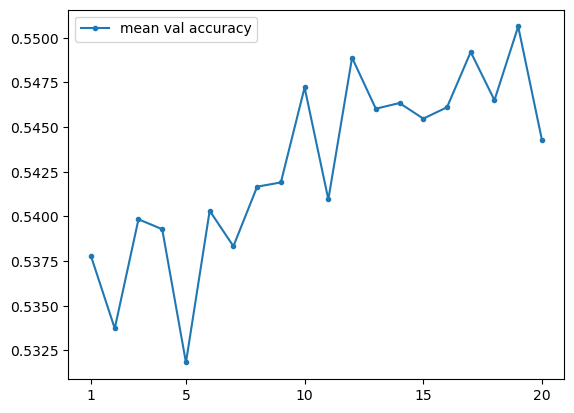

highest val accuracy = 0.5506349206349206
highest val accuracy when using previous 19 games


In [54]:
plot_train_val_test(xgb)

In [ ]:
xgb['chosen_n_games'] = 19

In [83]:
print(f"test accuracy at n_games = 19: {xgb['scores_1to20']['test_accuracys'][18]}")
print(f"test auc at n_games = 19: {xgb['scores_1to20']['aucs'][18]}")

test accuracy at n_games = 19: 0.5590740740740741
test auc at n_games = 19: 0.5566317174939961


## 4.2.a SVM (linear)

In [17]:
svc_linear['scores_1to20']={
    'val_score_arrays':[],
    'mean_train_accuracys':[], # obtain from averaging the train accuracys from the validation
    'mean_val_accuracys':[], # obtain from averaging the test accuracys from the validation
    'test_accuracys':[],
    'aucs':[]
}
for key in range(1,21):
    val_scores, test_accuracy, auc = model_scores(dict_metric_avg[key], svc_linear['best_model'])
    svc_linear['scores_1to20']['val_score_arrays'].append(val_scores)
    svc_linear['scores_1to20']['test_accuracys'].append(test_accuracy)
    svc_linear['scores_1to20']['aucs'].append(auc)
    # calculate the mean train accuracy from val_score_array
    svc_linear['scores_1to20']['mean_train_accuracys'].append(np.mean(val_scores['train_accuracy']))
    svc_linear['scores_1to20']['mean_val_accuracys'].append(np.mean(val_scores['test_accuracy']))




model done running. test accuracy = 0.537.
model done running. test accuracy = 0.533.
model done running. test accuracy = 0.535.
model done running. test accuracy = 0.537.
model done running. test accuracy = 0.536.
model done running. test accuracy = 0.537.
model done running. test accuracy = 0.534.
model done running. test accuracy = 0.541.
model done running. test accuracy = 0.541.
model done running. test accuracy = 0.534.
model done running. test accuracy = 0.537.
model done running. test accuracy = 0.541.
model done running. test accuracy = 0.543.
model done running. test accuracy = 0.547.
model done running. test accuracy = 0.546.
model done running. test accuracy = 0.547.
model done running. test accuracy = 0.546.
model done running. test accuracy = 0.545.
model done running. test accuracy = 0.546.
model done running. test accuracy = 0.544.


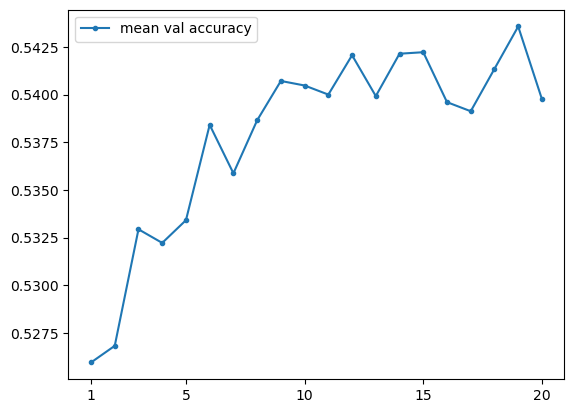

highest val accuracy = 0.5435714285714285
highest val accuracy when using previous 19 games


In [55]:
plot_train_val_test(svc_linear)

In [56]:
svc_linear['chosen_n_games'] = 19

In [102]:
pd.DataFrame(xgb['scores_1to20']['val_score_arrays'][19])

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.184837,0.016295,0.544048,0.622123,0.551259,0.674462
1,0.199539,0.013828,0.544841,0.618750,0.554953,0.677196
2,0.195855,0.014403,0.541270,0.611706,0.557956,0.668126
3,0.190653,0.013670,0.538492,0.609524,0.559406,0.670301
4,0.185917,0.013446,0.552778,0.617063,0.563112,0.674588


In [103]:
np.mean(xgb['scores_1to20']['val_score_arrays'][19]['test_accuracy']), np.mean(xgb['scores_1to20']['val_score_arrays'][19]['test_roc_auc'])

(0.5442857142857143, 0.5573371949986425)

## 4.2.b SVM RBF

In [19]:
svc['scores_1to20']={
    'val_score_arrays':[],
    'mean_train_accuracys':[], # obtain from averaging the train accuracys from the validation
    'mean_val_accuracys':[], # obtain from averaging the test accuracys from the validation
    'test_accuracys':[],
    'aucs':[]
}
for key in range(1,21):
    # for svm rbf, only pass 10000 rows to avoid extensive train time
    val_scores, test_accuracy, auc = model_scores(dict_metric_avg[key].sample(n=10000, random_state=42), 
                                                    svc['best_model'])
    svc['scores_1to20']['val_score_arrays'].append(val_scores)
    svc['scores_1to20']['test_accuracys'].append(test_accuracy)
    svc['scores_1to20']['aucs'].append(auc)
    # calculate the mean train accuracy from val_score_array
    svc['scores_1to20']['mean_train_accuracys'].append(np.mean(val_scores['train_accuracy']))
    svc['scores_1to20']['mean_val_accuracys'].append(np.mean(val_scores['test_accuracy']))

model done running. test accuracy = 0.526.
model done running. test accuracy = 0.522.
model done running. test accuracy = 0.525.
model done running. test accuracy = 0.521.
model done running. test accuracy = 0.529.
model done running. test accuracy = 0.530.
model done running. test accuracy = 0.540.
model done running. test accuracy = 0.553.
model done running. test accuracy = 0.548.
model done running. test accuracy = 0.549.
model done running. test accuracy = 0.552.
model done running. test accuracy = 0.540.
model done running. test accuracy = 0.545.
model done running. test accuracy = 0.543.
model done running. test accuracy = 0.547.
model done running. test accuracy = 0.548.
model done running. test accuracy = 0.551.
model done running. test accuracy = 0.551.
model done running. test accuracy = 0.553.
model done running. test accuracy = 0.552.


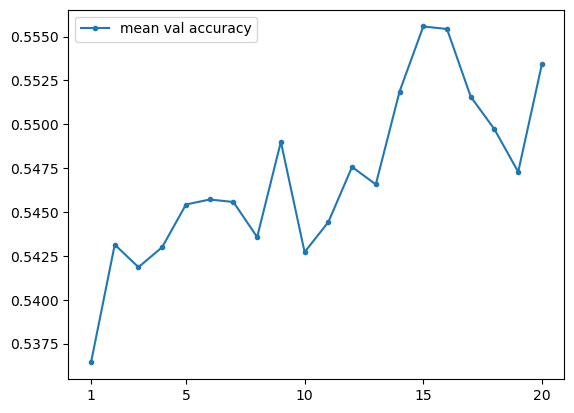

highest val accuracy = 0.5555714285714286
highest val accuracy when using previous 15 games


In [57]:
plot_train_val_test(svc)

In [58]:
svc['chosen_n_games'] = 15

In [ ]:
print(f"test accuracy at n_games = 15: {svc['scores_1to20']['test_accuracys'][14]}")
print(f"test auc at n_games = 15: {svc['scores_1to20']['aucs'][14]}")

test accuracy at n_games = 15: 0.547
test auc at n_games = 15: 0.5530468749999999


In [95]:
pd.DataFrame(svc['scores_1to20']['val_score_arrays'][14])

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,1.409163,1.714278,0.545714,0.639643,0.535708,0.727449
1,1.422676,1.761885,0.560000,0.632500,0.563636,0.726199
2,1.444790,1.742888,0.567143,0.635714,0.561085,0.724375
3,1.410865,1.868732,0.553571,0.644286,0.565626,0.722530
4,1.415839,1.865643,0.551429,0.641964,0.543996,0.725065


In [101]:
np.mean(svc['scores_1to20']['val_score_arrays'][14]['test_accuracy']), np.mean(svc['scores_1to20']['val_score_arrays'][14]['test_roc_auc'])

(0.5555714285714286, 0.5540101547865524)

---
# 5. weighted average of each game

## 5.1 extreme gradient boost 

In [ ]:
xgb['metric_each_game_n_games'] = select_n_games(xgb['chosen_n_games'])
xgb['df_weighted_n_games'] = {key: None for key in np.arange(0,0.501,0.005)} 
for key, value in xgb['df_weighted_n_games'].items():
    # key is the temperature 
    # value will be the df that cols are weighted with this temp
    this_logit = np.arange(xgb['chosen_n_games']-1, -1, -1)
    this_weight = softmax_with_temperature(this_logit, key)
    xgb['df_weighted_n_games'][key] = weight_each_game(xgb['metric_each_game_n_games'], this_weight)

In [23]:
xgb['scores_weighted']={
    'val_score_arrays':[],
    'mean_train_accuracys':[], # obtain from averaging the train accuracys from the validation
    'mean_val_accuracys':[], # obtain from averaging the test accuracys from the validation
    'test_accuracys':[],
    'aucs':[]
}
for key, value in xgb['df_weighted_n_games'].items():
    val_scores, test_accuracy, auc = model_scores(value, xgb['best_model'])
    xgb['scores_weighted']['val_score_arrays'].append(val_scores)
    xgb['scores_weighted']['test_accuracys'].append(test_accuracy)
    xgb['scores_weighted']['aucs'].append(auc)
    # calculate the mean train accuracy from val_score_array
    xgb['scores_weighted']['mean_train_accuracys'].append(np.mean(val_scores['train_accuracy']))
    xgb['scores_weighted']['mean_val_accuracys'].append(np.mean(val_scores['test_accuracy']))
    print(f'{key} done.')

/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.558.
0.0 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.561.
0.005 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.01 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.015 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.538.
0.02 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.558.
0.025 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.564.
0.03 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.559.
0.035 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.541.
0.04 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.541.
0.045 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.552.
0.05 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.556.
0.055 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.06 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.552.
0.065 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:54:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.564.
0.07 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.538.
0.075 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.541.
0.08 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.547.
0.085 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.09 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.544.
0.095 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.1 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.555.
0.105 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.562.
0.11 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.
0.115 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.547.
0.12 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.535.
0.125 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.556.
0.13 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.559.
0.135 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.558.
0.14 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.145 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.529.
0.15 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.553.
0.155 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.553.
0.16 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.165 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.535.
0.17 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.544.
0.17500000000000002 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.
0.18 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.520.
0.185 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.524.
0.19 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.518.
0.195 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.
0.2 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.548.
0.20500000000000002 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.527.
0.21 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.512.
0.215 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.22 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.
0.225 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.23 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.532.
0.23500000000000001 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.552.
0.24 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.245 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.545.
0.25 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.255 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.535.
0.26 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.527.
0.265 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.538.
0.27 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.
0.275 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.509.
0.28 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.
0.28500000000000003 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.
0.29 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.521.
0.295 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.498.
0.3 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.305 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.547.
0.31 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.
0.315 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.32 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.325 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.
0.33 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.529.
0.335 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.524.
0.34 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.524.
0.34500000000000003 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.547.
0.35000000000000003 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.532.
0.355 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.36 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.365 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.529.
0.37 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.517.
0.375 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.529.
0.38 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.529.
0.385 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.39 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.547.
0.395 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.548.
0.4 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.405 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.535.
0.41000000000000003 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.530.
0.41500000000000004 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.556.
0.42 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.561.
0.425 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.533.
0.43 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.435 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.550.
0.44 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.
0.445 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.539.
0.45 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.542.
0.455 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.552.
0.46 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.535.
0.465 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.552.
0.47000000000000003 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.558.
0.47500000000000003 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.552.
0.48 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.520.
0.485 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.545.
0.49 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.541.
0.495 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

model done running. test accuracy = 0.536.
0.5 done.


/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


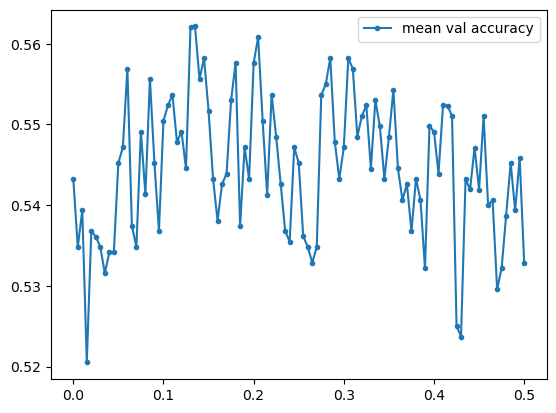

highest val accuracy = 0.5621409535090317
highest val accuracy when using temp = 0.135


In [59]:
plot_train_val_test_weighted(xgb, list(xgb['df_weighted_n_games'].keys()))


In [88]:
print(f"test accuracy at n_games = 19 and temp = 0.135: {xgb['scores_weighted']['test_accuracys'][27]}")
print(f"test auc at n_games = 19 and temp = 0.135: {xgb['scores_weighted']['aucs'][27]}")
# print(list(xgb['df_weighted_n_games'].keys())[27])

test accuracy at n_games = 19 and temp = 0.135: 0.5590909090909091
test auc at n_games = 19 and temp = 0.135: 0.5465434350132626


In [105]:
pd.DataFrame(xgb['scores_weighted']['val_score_arrays'][27])

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.081727,0.012628,0.564935,0.714402,0.543346,0.823754
1,0.080825,0.014460,0.548701,0.712775,0.492900,0.803379
2,0.079049,0.013065,0.540717,0.714634,0.529655,0.823934
3,0.080583,0.012569,0.583062,0.747967,0.562907,0.854397
4,0.082543,0.013035,0.573290,0.720325,0.560436,0.823267


In [104]:
np.mean(xgb['scores_weighted']['val_score_arrays'][27]['test_accuracy']), np.mean(xgb['scores_weighted']['val_score_arrays'][27]['test_roc_auc'])

(0.5621409535090317, 0.5378487367139162)

## 5.2.a SVM (linear)

In [60]:
svc_linear['metric_each_game_n_games'] = select_n_games(svc_linear['chosen_n_games'])
svc_linear['df_weighted_n_games'] = {key: None for key in np.arange(0,0.501,0.005)} 
for key, value in svc_linear['df_weighted_n_games'].items():
    # key is the temperature 
    # value will be the df that cols are weighted with this temp
    this_logit = np.arange(svc_linear['chosen_n_games']-1, -1, -1)
    this_weight = softmax_with_temperature(this_logit, key)
    svc_linear['df_weighted_n_games'][key] = weight_each_game(svc_linear['metric_each_game_n_games'], this_weight)

In [61]:
svc_linear['scores_weighted']={
    'val_score_arrays':[],
    'mean_train_accuracys':[], # obtain from averaging the train accuracys from the validation
    'mean_val_accuracys':[], # obtain from averaging the test accuracys from the validation
    'test_accuracys':[],
    'aucs':[]
}
for key, value in svc_linear['df_weighted_n_games'].items():
    val_scores, test_accuracy, auc = model_scores(value, svc_linear['best_model'])
    svc_linear['scores_weighted']['val_score_arrays'].append(val_scores)
    svc_linear['scores_weighted']['test_accuracys'].append(test_accuracy)
    svc_linear['scores_weighted']['aucs'].append(auc)
    # calculate the mean train accuracy from val_score_array
    svc_linear['scores_weighted']['mean_train_accuracys'].append(np.mean(val_scores['train_accuracy']))
    svc_linear['scores_weighted']['mean_val_accuracys'].append(np.mean(val_scores['test_accuracy']))
    print(f'{key} done.')

model done running. test accuracy = 0.559.
0.0 done.
model done running. test accuracy = 0.558.
0.005 done.
model done running. test accuracy = 0.562.
0.01 done.
model done running. test accuracy = 0.561.
0.015 done.
model done running. test accuracy = 0.565.
0.02 done.
model done running. test accuracy = 0.564.
0.025 done.
model done running. test accuracy = 0.558.
0.03 done.
model done running. test accuracy = 0.553.
0.035 done.
model done running. test accuracy = 0.553.
0.04 done.
model done running. test accuracy = 0.561.
0.045 done.
model done running. test accuracy = 0.568.
0.05 done.
model done running. test accuracy = 0.573.
0.055 done.
model done running. test accuracy = 0.576.
0.06 done.
model done running. test accuracy = 0.574.
0.065 done.
model done running. test accuracy = 0.577.
0.07 done.
model done running. test accuracy = 0.582.
0.075 done.
model done running. test accuracy = 0.573.
0.08 done.
model done running. test accuracy = 0.570.
0.085 done.
model done running. 

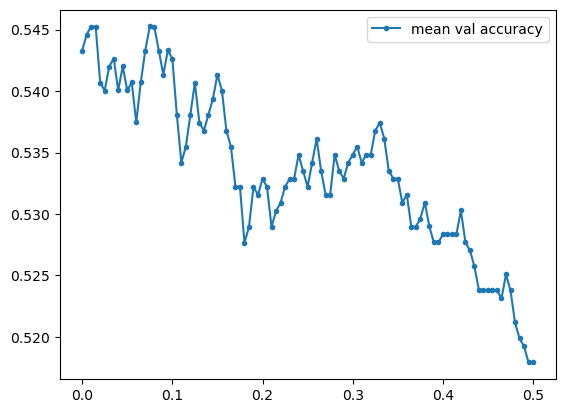

highest val accuracy = 0.5452536063285249
highest val accuracy when using temp = 0.075


In [62]:
plot_train_val_test_weighted(svc_linear, list(svc_linear['df_weighted_n_games'].keys()))


## 5.2.b SVM RBF

In [ ]:
svc['metric_each_game_n_games'] = select_n_games(svc['chosen_n_games'])
svc['df_weighted_n_games'] = {key: None for key in np.arange(0,0.501,0.05)} 
for key, value in svc['df_weighted_n_games'].items():
    # key is the temperature 
    # value will be the df that cols are weighted with this temp
    this_logit = np.arange(svc['chosen_n_games']-1, -1, -1)
    this_weight = softmax_with_temperature(this_logit, key)
    svc['df_weighted_n_games'][key] = weight_each_game(svc['metric_each_game_n_games'], this_weight)

In [68]:
svc['scores_weighted']={
    'val_score_arrays':[],
    'mean_train_accuracys':[], # obtain from averaging the train accuracys from the validation
    'mean_val_accuracys':[], # obtain from averaging the test accuracys from the validation
    'test_accuracys':[],
    'aucs':[]
}
for key, value in svc['df_weighted_n_games'].items():
    val_scores, test_accuracy, auc = model_scores(value, 
                                                  svc['best_model'])
    svc['scores_weighted']['val_score_arrays'].append(val_scores)
    svc['scores_weighted']['test_accuracys'].append(test_accuracy)
    svc['scores_weighted']['aucs'].append(auc)
    # calculate the mean train accuracy from val_score_array
    svc['scores_weighted']['mean_train_accuracys'].append(np.mean(val_scores['train_accuracy']))
    svc['scores_weighted']['mean_val_accuracys'].append(np.mean(val_scores['test_accuracy']))
    print(f'{key} done.')

model done running. test accuracy = 0.569.
0.0 done.
model done running. test accuracy = 0.565.
0.05 done.
model done running. test accuracy = 0.568.
0.1 done.
model done running. test accuracy = 0.570.
0.15000000000000002 done.
model done running. test accuracy = 0.562.
0.2 done.
model done running. test accuracy = 0.564.
0.25 done.
model done running. test accuracy = 0.556.
0.30000000000000004 done.
model done running. test accuracy = 0.551.
0.35000000000000003 done.
model done running. test accuracy = 0.545.
0.4 done.
model done running. test accuracy = 0.539.
0.45 done.
model done running. test accuracy = 0.547.
0.5 done.


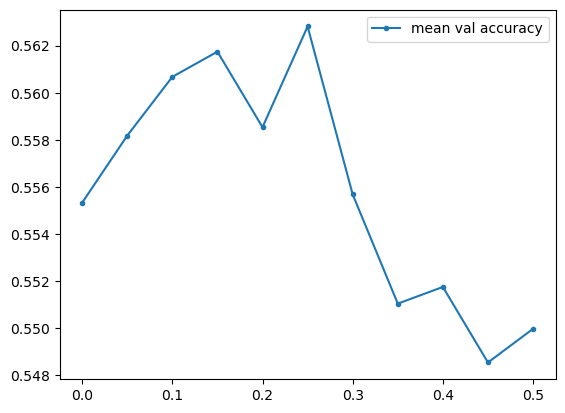

highest val accuracy = 0.5628151260504202
highest val accuracy when using temp = 0.25


In [75]:
plot_train_val_test_weighted(svc, list(svc['df_weighted_n_games'].keys()))

In [93]:
print(f"test accuracy at n_games = 15 and temp = 0.25: {svc['scores_weighted']['test_accuracys'][5]}")
print(f"test auc at n_games = 15 and temp = 0.25: {svc['scores_weighted']['aucs'][5]}")
# print(list(svc['df_weighted_n_games'].keys())[5])

test accuracy at n_games = 15 and temp = 0.25: 0.5640599001663894
test auc at n_games = 15 and temp = 0.25: 0.5583927817410049


In [ ]:
pd.DataFrame(svc['scores_weighted']['val_score_arrays'][5])

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.272801,0.451701,0.565062,0.672914,0.536190,0.771296
1,0.306290,0.297586,0.552585,0.661758,0.534894,0.774397
2,0.247012,0.288051,0.551786,0.667707,0.553690,0.775489
3,0.242133,0.299925,0.576786,0.669492,0.548711,0.779087
4,0.243657,0.298849,0.567857,0.668599,0.542432,0.774884


In [99]:
np.mean(svc['scores_weighted']['val_score_arrays'][5]['test_accuracy']), np.mean(svc['scores_weighted']['val_score_arrays'][5]['test_roc_auc'])

(0.5628151260504202, 0.5431834301513232)

---
# 6. export all the mean val score data to Marcus

In [80]:
dict_for_marcus = {
    'model':[],
    'type':[],
    'key':[],
    'value':[]
}
for i in [xgb, svc_linear, svc]:
    if i == xgb:
        name = 'xgb'
    elif i == svc_linear:
        name = 'svc_linear'
    else: 
        name = 'svc'
    dict_for_marcus['model'].extend(np.array([name]*20))
    dict_for_marcus['type'].extend(np.array(['simple_average']*20))
    dict_for_marcus['key'].extend(np.arange(1,21))
    dict_for_marcus['value'].extend(i['scores_1to20']['mean_val_accuracys'])

    dict_for_marcus['model'].extend(np.array([name]*len(i['df_weighted_n_games'])))
    dict_for_marcus['type'].extend(np.array(['weighted_average']*len(i['df_weighted_n_games'])))
    dict_for_marcus['key'].extend(list(i['df_weighted_n_games'].keys()))
    dict_for_marcus['value'].extend(i['scores_weighted']['mean_val_accuracys'])
    

df_for_marcus = pd.DataFrame(dict_for_marcus)
df_for_marcus.tail()
    

,model,type,key,value
268,svc,weighted_average,0.30,0.555676
269,svc,weighted_average,0.35,0.551035
270,svc,weighted_average,0.40,0.551744
271,svc,weighted_average,0.45,0.548533
272,svc,weighted_average,0.50,0.549964


In [81]:
df_for_marcus.to_csv('data_2014_to_2024/val_scores_xgb_svclinear_svc.csv')

In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt
# df_for_marcus = pd.read_csv('data_2014_to_2024/val_scores_xgb_svclinear_svc.csv').iloc[:,1:]
# df_for_marcus.tail()

In [11]:
# # df_for_marcus[df_for_marcus['model']=='xgb' and df_for_marcus['type']=='weighted_average']
# xgb_to_plot = df_for_marcus[df_for_marcus['model']=='xgb'][df_for_marcus['type']=='weighted_average']
# plt.plot(xgb_to_plot['key'], xgb_to_plot['value'])